In [1]:
import requests
import pandas as pd
import geopandas as gpd
import plotly.express as px
import folium
from shapely.geometry import shape

print("仪表盘已准备就绪！")

仪表盘已准备就绪！


In [2]:
# API 的 URL
API_URL = "http://127.0.0.1:5000/api/measurements"

# 设置请求参数
params = {
    'pollutant': 'Ozono',
    'limit': 1000
}

print(f"正在从 API 获取数据: {API_URL} with params {params}")
response = requests.get(API_URL, params=params)

# 检查请求是否成功
if response.status_code == 200:
    data = response.json()
    print(f"成功获取 {len(data)} 条记录。")
    # 将 JSON 数据转换为 GeoDataFrame
    # 将 location (GeoJSON) 转换为 geometry
    geometry = [shape(item['location']) for item in data]
    gdf_from_api = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")
    gdf_from_api['timestamp'] = pd.to_datetime(gdf_from_api['timestamp'])
else:
    print(f"获取数据失败，状态码: {response.status_code}")
    print(response.text)
    
gdf_from_api.head()

正在从 API 获取数据: http://127.0.0.1:5000/api/measurements with params {'pollutant': 'Ozono', 'limit': 1000}
成功获取 1000 条记录。


,location,pollutant,sensor_id,station_name,timestamp,value,geometry
0,"{'coordinates': [10.48078183, 45.46375819], 't...",Ozono,6832,Lonato del Garda v.del Marchesino,2024-12-06 17:00:00,1.3,POINT (10.48078 45.46376)
1,"{'coordinates': [9.35166247, 45.84221272], 'ty...",Ozono,9972,Valmadrera v.Pozzi,2024-12-06 17:00:00,59.0,POINT (9.35166 45.84221)
2,"{'coordinates': [9.49754261, 45.91279097], 'ty...",Ozono,9991,Moggio Loc. Penscei,2024-12-06 17:00:00,84.8,POINT (9.49754 45.91279)
3,"{'coordinates': [9.49528589, 45.30278678], 'ty...",Ozono,10454,Lodi S.Alberto,2024-12-06 17:00:00,7.0,POINT (9.49529 45.30279)
4,"{'coordinates': [9.66625758, 45.23349689], 'ty...",Ozono,10463,Bertonico v.Moro,2024-12-06 17:00:00,12.3,POINT (9.66626 45.2335)


In [3]:
# 创建一个以米兰为中心的地图
m = folium.Map(location=[45.4642, 9.1900], zoom_start=10)

# 在地图上为每个测量点添加标记
for idx, row in gdf_from_api.iterrows():
    popup_text = f"""
    <b>站名:</b> {row['station_name']}<br>
    <b>污染物:</b> {row['pollutant']}<br>
    <b>数值:</b> {row['value']}<br>
    <b>时间:</b> {row['timestamp'].strftime('%Y-%m-%d %H:%M')}
    """
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# 显示地图
m

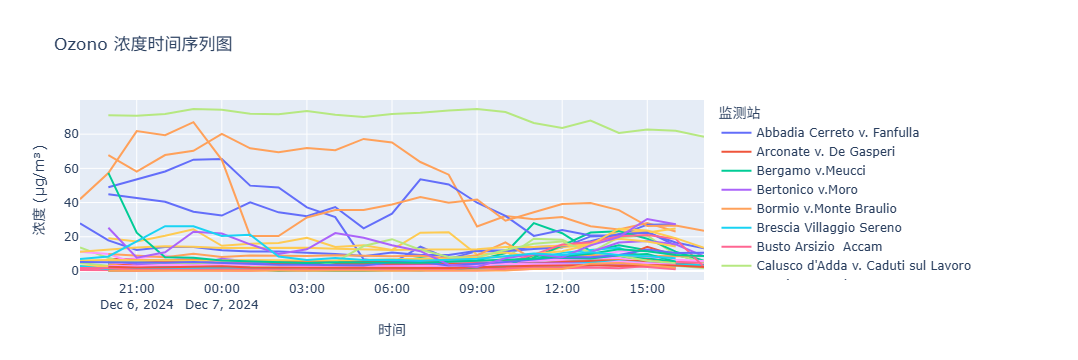

In [5]:
# 按站点和时间对数据进行排序
gdf_from_api_sorted = gdf_from_api.sort_values(by=['station_name', 'timestamp'])

fig = px.line(
    gdf_from_api_sorted,
    x='timestamp',
    y='value',
    color='station_name',  # 按站点用不同颜色区分
    title=f'{params["pollutant"]} 浓度时间序列图',
    labels={'timestamp': '时间', 'value': '浓度 (µg/m³)', 'station_name': '监测站'}
)
fig.show()